In [221]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images
x_train = x_train.reshape(60000, -1).astype("float32") / 255.0
x_test  = x_test.reshape(10000, -1).astype("float32") / 255.0


#### Using a PCA to reduce input dimensionality

In [222]:
pca = PCA(n_components=50)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

#### Creating an MLP

In [223]:
# Basic MLP
model = models.Sequential([
    layers.Input(shape=(50,)),
    layers.Dense(20, activation="relu"),
    layers.Dense(15, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 15)                  │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 10)                  │             160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,495 (5.84 KB)

 Trainable params: 1,495 (5.84 KB)

 Non-trainable params: 0 (0.00 B)

#### Training an MLP

In [224]:
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6506 - loss: 1.1224 - val_accuracy: 0.8975 - val_loss: 0.3653
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8963 - loss: 0.3583 - val_accuracy: 0.9270 - val_loss: 0.2537
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9164 - loss: 0.2854 - val_accuracy: 0.9368 - val_loss: 0.2155
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9266 - loss: 0.2489 - val_accuracy: 0.9440 - val_loss: 0.1911
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9331 - loss: 0.2255 - val_accuracy: 0.9480 - val_loss: 0.1786
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.9379 - loss: 0.2058
Test accuracy: 0.9379000067710876


In [225]:
W1 = model.layers[0].weights[0]
W2 = model.layers[1].weights[0]
W3 = model.layers[2].weights[0]

#### Sparse mask function to prune weights from the model (Update epsilon to change sparsity)

In [226]:
def create_sparse_mask(shape, epsilon=5):  
    # SET paper uses epsilon = 20
    fan_in = shape[0]
    prob = epsilon / fan_in
    return np.random.rand(*shape) < prob

In [227]:
mask1 = create_sparse_mask(W1.shape)
mask2 = create_sparse_mask(W2.shape)
mask3 = create_sparse_mask(W3.shape)

In [228]:
W1.assign(W1 * mask1)
W2.assign(W2 * mask2)
W3.assign(W3 * mask3)

<tf.Tensor: shape=(15, 10), dtype=float32, numpy=
array([[-0.        , -0.        , -0.        ,  0.        ,  0.        ,
         0.32099608, -0.62235224,  0.        ,  0.        ,  0.75065637],
       [-0.        ,  0.        ,  0.        ,  0.        , -0.46760374,
         0.        , -0.639622  ,  0.07313336,  0.        , -0.        ],
       [ 0.        ,  0.2541852 , -0.        , -0.7611713 , -0.11208945,
        -0.5808851 , -0.27930057,  0.43222764,  0.        , -0.43179396],
       [-0.        , -0.77793396, -0.        ,  0.6920242 , -0.44653732,
         0.        , -0.        ,  0.        , -0.        , -0.47159064],
       [ 0.        , -0.97138405,  0.18312956, -0.24156106, -0.73283345,
        -0.2025358 , -0.        , -0.        ,  0.        ,  0.2409625 ],
       [-0.        ,  0.        , -0.        , -0.        , -0.4563717 ,
        -0.        , -0.        ,  0.        , -0.        ,  0.        ],
       [-0.        , -0.71357685,  0.        ,  0.0132483 ,  0.33199

#### Training the sparse model (Realized that the optimizer would still update the 0 weights so I had to make a custom training loop, see further down)

In [229]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7260 - loss: 0.9668 - val_accuracy: 0.9197 - val_loss: 0.3125
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9083 - loss: 0.3206 - val_accuracy: 0.9390 - val_loss: 0.2220
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9232 - loss: 0.2630 - val_accuracy: 0.9438 - val_loss: 0.1949
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9301 - loss: 0.2375 - val_accuracy: 0.9478 - val_loss: 0.1794
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9351 - loss: 0.2197 - val_accuracy: 0.9530 - val_loss: 0.1655
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.9429 - loss: 0.1982
Test accuracy: 0.9429000020027161


#### Found out that the zero count was way too high (AKA the zero weights (non connections) get updated during regular training)

In [230]:
W1_after = model.layers[0].weights[0].numpy()
W2_after = model.layers[1].weights[0].numpy()
W3_after = model.layers[2].weights[0].numpy()

print("Non-zero connections in W1:", np.count_nonzero(W1_after))
print("Non-zero connections in W2:", np.count_nonzero(W2_after))
print("Non-zero connections in W3:", np.count_nonzero(W3_after))

Non-zero connections in W1: 1000
Non-zero connections in W2: 284
Non-zero connections in W3: 146


#### Created a custom training loop

In [231]:
batch_size = 128
N = x_train.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(N).batch(batch_size)

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()


In [232]:
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        preds = model(x_batch)
        loss = loss_fn(y_batch, preds)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Apply masks
    W1.assign(W1 * mask1)
    W2.assign(W2 * mask2)
    W3.assign(W3 * mask3)

    # accuracy
    pred_classes = tf.argmax(preds, axis=1)
    y_batch = tf.cast(y_batch, tf.int64)
    acc = tf.reduce_mean(tf.cast(pred_classes == y_batch, tf.float32))

    return float(loss), acc

In [233]:
for epoch in range(30):
    bar = tqdm(dataset)
    for x_batch, y_batch in bar:
        t0 = time.time()
        loss_value, acc_value = train_step(x_batch, y_batch)
        dt = time.time() - t0
        bar.set_postfix({
            "dt": f"{dt:.4f}s",
            "loss": f"{loss_value:.4f}",
            "acc": f"{acc_value:.4f}"
        })
    print(f"Epoch {epoch+1} done")

100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 270.49it/s, dt=0.1932s, loss=1.4651, acc=0.5000]


Epoch 1 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 461.89it/s, dt=0.0010s, loss=1.1780, acc=0.6042]


Epoch 2 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 448.20it/s, dt=0.0005s, loss=1.0163, acc=0.6667]


Epoch 3 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 465.79it/s, dt=0.0005s, loss=0.9440, acc=0.6979]


Epoch 4 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 464.85it/s, dt=0.0015s, loss=0.7043, acc=0.7604]


Epoch 5 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 447.19it/s, dt=0.0010s, loss=0.7285, acc=0.7396]


Epoch 6 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 463.87it/s, dt=0.0010s, loss=0.7537, acc=0.7396]


Epoch 7 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 464.77it/s, dt=0.0010s, loss=0.6337, acc=0.7917]


Epoch 8 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 456.88it/s, dt=0.0010s, loss=0.7951, acc=0.7604]


Epoch 9 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 467.09it/s, dt=0.0010s, loss=0.6058, acc=0.8229]


Epoch 10 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 473.27it/s, dt=0.0010s, loss=0.8283, acc=0.7396]


Epoch 11 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 473.01it/s, dt=0.0010s, loss=0.7407, acc=0.7917]


Epoch 12 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 463.84it/s, dt=0.0010s, loss=0.7626, acc=0.7292]


Epoch 13 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 459.06it/s, dt=0.0010s, loss=0.7963, acc=0.8021]


Epoch 14 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 441.95it/s, dt=0.0005s, loss=0.6348, acc=0.8125]


Epoch 15 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 466.84it/s, dt=0.0010s, loss=0.6948, acc=0.7917]


Epoch 16 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 472.00it/s, dt=0.0010s, loss=0.6080, acc=0.7812]


Epoch 17 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 474.70it/s, dt=0.0015s, loss=0.6217, acc=0.8125]


Epoch 18 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 472.95it/s, dt=0.0005s, loss=0.5537, acc=0.8438]


Epoch 19 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 471.31it/s, dt=0.0010s, loss=0.4518, acc=0.8646]


Epoch 20 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 472.51it/s, dt=0.0005s, loss=0.5292, acc=0.8021]


Epoch 21 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 473.71it/s, dt=0.0005s, loss=0.8178, acc=0.7292]


Epoch 22 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 469.17it/s, dt=0.0010s, loss=0.4797, acc=0.8854]


Epoch 23 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 463.83it/s, dt=0.0010s, loss=0.5764, acc=0.8333]


Epoch 24 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 447.22it/s, dt=0.0010s, loss=0.5699, acc=0.8333]


Epoch 25 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 510.62it/s, dt=0.0005s, loss=0.5139, acc=0.8021]


Epoch 26 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 509.59it/s, dt=0.0005s, loss=0.5579, acc=0.8125]


Epoch 27 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 500.27it/s, dt=0.0010s, loss=0.3961, acc=0.8854]


Epoch 28 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 509.82it/s, dt=0.0010s, loss=0.5788, acc=0.8125]


Epoch 29 done


100%|██████████████████████████████████████████| 469/469 [00:00<00:00, 508.44it/s, dt=0.0010s, loss=0.6221, acc=0.8333]

Epoch 30 done


#### Now we truly have sparsity :)

In [234]:
W1_after = model.layers[0].weights[0].numpy()
W2_after = model.layers[1].weights[0].numpy()
W3_after = model.layers[2].weights[0].numpy()

print("Non-zero connections in W1:", np.count_nonzero(W1_after))
print("Non-zero connections in W2:", np.count_nonzero(W2_after))
print("Non-zero connections in W3:", np.count_nonzero(W3_after))

Non-zero connections in W1: 104
Non-zero connections in W2: 74
Non-zero connections in W3: 58


#### Accuracy is pretty bad since it is randomly deciding which connections matter. It could even prune edges towards the output so that a single output might have 0 connections XD which is not good ofc
#### This is where the regrow comes in (not implemented here)

In [235]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.8202 - loss: 0.5747
Test accuracy: 0.8202000260353088


#### Drawing the network (please only use on small models XD)

In [236]:
def draw_layer_connections(W, layer_in_size, layer_out_size, title="Layer connections"):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.axis("off")

    # Positions of neurons
    x_in, x_out = 0, 1
    y_in = np.linspace(0, 1, layer_in_size)
    y_out = np.linspace(0, 1, layer_out_size)

    # Draw neurons
    ax.scatter([x_in] * layer_in_size, y_in, s=30, color="blue")
    ax.scatter([x_out] * layer_out_size, y_out, s=30, color="red")

    # Draw connections
    for i in range(layer_in_size):
        for j in range(layer_out_size):
            if W[i, j] != 0:  # check active connection
                ax.plot([x_in, x_out], [y_in[i], y_out[j]],
                        linewidth=0.5, color="gray")

    plt.show()


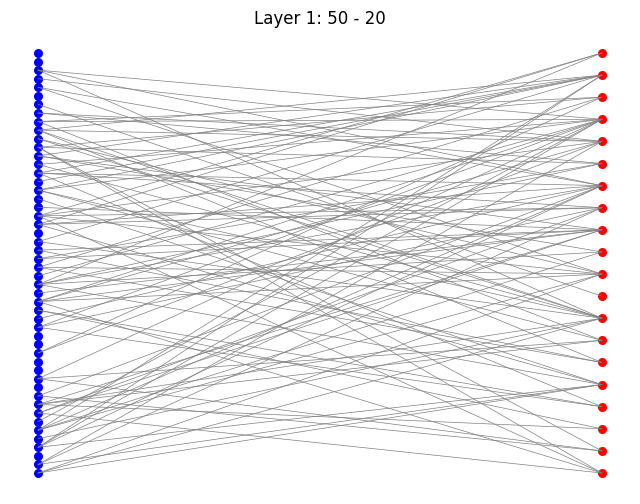

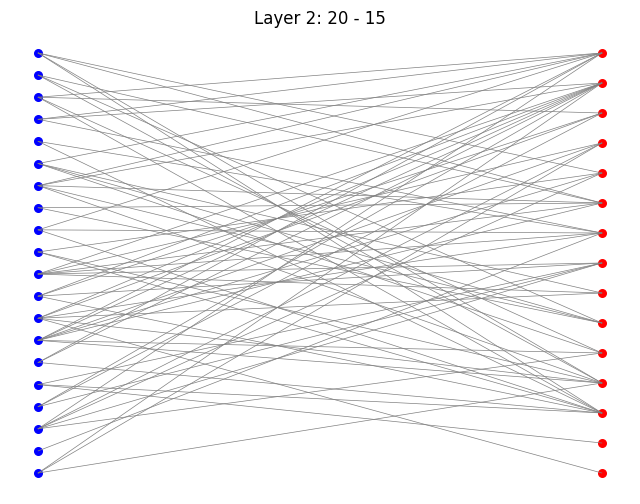

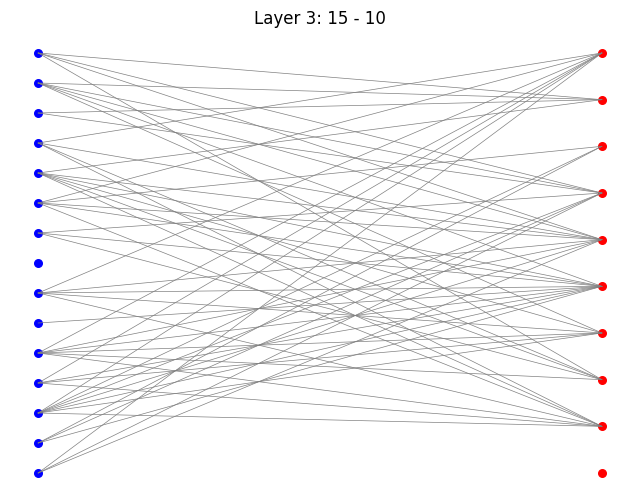

In [237]:
W1_after = model.layers[0].get_weights()[0]
W2_after = model.layers[1].get_weights()[0]
W3_after = model.layers[2].get_weights()[0]

draw_layer_connections(W1_after, 50, 20, "Layer 1: 50 - 20")
draw_layer_connections(W2_after, 20, 15, "Layer 2: 20 - 15")
draw_layer_connections(W3_after, 15, 10, "Layer 3: 15 - 10")
